# Guide
## Data
[[Google Drive] /Data/Initial/Step1.zip](https://drive.google.com/file/d/1LpnhjeBOoLH-QwbVOovCk-OpdpmIQAaZ/view?usp=sharing)
## Code
In [3] `base_dir` : 실제 데이터 경로로 변경 필요

---

# Purpose
(compared to `3. EarlyStopping`)  
- 과적합 방지  
DropOut Layer 추가
<br><br>
- Validation Accuracy와 Loss 그래프의 진동 폭 감소  
Batch Normalization layer 추가

## Alternation
(compared to `3. EarlyStopping`)  
모델의 레이어 구성 변경

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
import os

2024-11-20 15:42:38.993660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
image_size = (400, 400)
batch_size = 32

In [3]:
# 데이터셋 로드
from tensorflow.keras.utils import image_dataset_from_directory

# 실제 데이터의 경로로 변경 필요
base_dir = "/tf/Fixed_Data/Data_Initial/Step1"

train_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=image_size,
    batch_size=batch_size)

validation_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'validation'),
    image_size=image_size,
    batch_size=batch_size)

test_dataset = image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=image_size,
    batch_size=batch_size)

Found 1732 files belonging to 2 classes.
Found 494 files belonging to 2 classes.
Found 249 files belonging to 2 classes.


2024-11-20 15:42:40.373247: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 15:42:40.376468: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 15:42:40.376552: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 모델 레이어 구성 변경
BatchNormalization, Dropout layer 추가  
ReLU( ) : Conv2D의 파라미터가 아닌 layer로 설정 → BatchNormalization 후 수행

In [4]:
# 모델 레이어 구성
inputs = keras.Input(shape=(400, 400, 3))

x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(filters=32, kernel_size=3)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=64, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=128, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3)(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.25)(x)
x = layers.MaxPooling2D(pool_size=2)(x)

x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

x = layers.Flatten()(x)
x = layers.Dropout(0.25)(x)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 398, 398, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 398, 398, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 398, 398, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 199, 199, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 197, 64)      18496 

In [6]:
model.compile(optimizer='rmsprop',
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

# EarlyStopping 콜백 설정
early_stopping = EarlyStopping(
    monitor='val_loss',       # 검증 손실을 기준으로 학습 중단
    patience=5,               # 성능이 개선되지 않는 에포크 수 (5회 연속 개선 없을 시 중단)
    restore_best_weights=True # 최적의 가중치 복원
)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=100,
    callbacks=[early_stopping],
    batch_size=batch_size)

Epoch 1/100


2024-11-20 15:42:41.546510: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-11-20 15:42:42.093060: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-11-20 15:42:42.539794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-11-20 15:42:42.540146: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdf0e20cce0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-20 15:42:42.540161: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-11-20 15:42:42.543073: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:

55/55 [==============================] - 10s 111ms/step - loss: 4.6697 - accuracy: 0.7367 - val_loss: 1.0852 - val_accuracy: 0.5405
Epoch 2/100
55/55 [==============================] - 6s 99ms/step - loss: 0.6350 - accuracy: 0.8054 - val_loss: 1.6221 - val_accuracy: 0.5040
Epoch 3/100
55/55 [==============================] - 6s 99ms/step - loss: 0.5272 - accuracy: 0.8291 - val_loss: 14.1555 - val_accuracy: 0.5587
Epoch 4/100
55/55 [==============================] - 6s 99ms/step - loss: 0.3910 - accuracy: 0.8435 - val_loss: 2.1292 - val_accuracy: 0.6619
Epoch 5/100
55/55 [==============================] - 6s 100ms/step - loss: 0.4779 - accuracy: 0.8516 - val_loss: 20.0059 - val_accuracy: 0.4474
Epoch 6/100
55/55 [==============================] - 6s 99ms/step - loss: 0.3141 - accuracy: 0.8932 - val_loss: 0.4591 - val_accuracy: 0.8482
Epoch 7/100
55/55 [==============================] - 6s 99ms/step - loss: 0.3275 - accuracy: 0.8961 - val_loss: 0.5765 - val_accuracy: 0.7267
Epoch 8/100
5

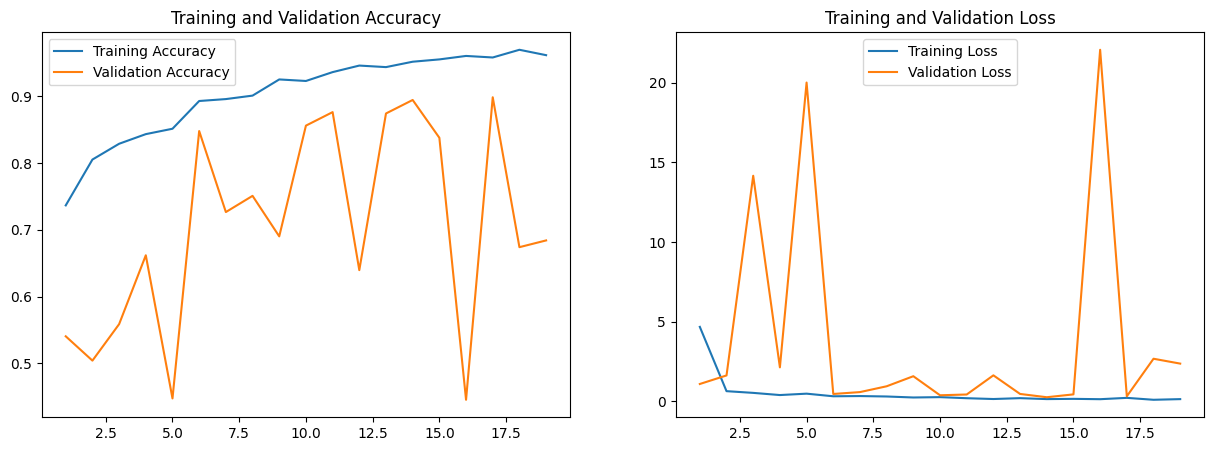

In [9]:
# 훈련 정확도와 손실 그래프 생성
import matplotlib.pyplot as plt 

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Analysis - Training & Validation

## 불안정
Validation의 Accuracy, Loss 그래프의 진동 폭이 여전히 크지만 이전 모델에 비해 확연히 감소
  
---

In [10]:
test_loss, test_acc = model.evaluate(test_dataset)

print(f"test accuracy: {test_acc}")
print(f"test loss: {test_loss}")

8/8 [==============================] - 1s 57ms/step - loss: 0.2207 - accuracy: 0.9157
test accuracy: 0.9156626462936401
test loss: 0.22069142758846283


# Analysis - Test
(compared to `3. EarlyStopping`)  
Accuracy : 86% → 91%  
Loss : 0.2961 → 0.2207  
꽤 향상된 성능을 가짐